<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Final Project - Stable computation of differentiation matrices with RBFs  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@usm.cl` - **rol:** 201104012-0

_DI UTFSM. February 2018._

In [1]:
#%matplotlib notebook
%matplotlib inline 

import numba
import numpy as np
import numpy.fft as fft

import scipy as sp
from scipy.sparse import csr_matrix, identity, kron
from scipy.sparse.linalg import spsolve
from scipy.linalg import toeplitz

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed, IntSlider, FloatSlider
import ghalton
import time

### Helper functions

In [2]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def wireframe_plot(xx, yy, vv, title=None, figsize=(10,7)):  
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(xx, yy, vv, linewidth=1, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    if title is not None:
        plt.title(title)
    plt.show()

def surface_plot(xx, yy, vv, title=None, figsize=(10,7)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, vv, linewidth=10, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    if title is not None:
        plt.title(title)
    plt.show()

Solving the Poisson equation:

$$
\Delta u(x,y) = u_{xx}(x,y) + u_{yy}(x,y) = f(x,y)
$$

#### Test functions

In [3]:
def f0(x,y):
    return np.zeros(x.shape)

def f1(x,y):
    return 10*np.sin(8*x*(y-1))

def f2(x,y):
    return -5*np.pi**2*np.sin(2*np.pi*x)*np.sin(np.pi*y)

def u2(x,y):
    return np.sin(2*np.pi*x)*np.sin(np.pi*y)

***
***
## Finite differences

In this section we implement finite differences of second order, as a baseline method used for with comparison spectral and RBF implementations. 

In [9]:
def fd_poisson_solver(N=32, f_func=None, g_func=None):
    """
    Code taken from:
    https://github.com/tclaudioe/Scientific-Computing/blob/master/SC2/U4_EDP_elipticas.ipynbt
    """
    # Discretize x and y
    x = np.linspace(-1., 1., N+1)
    y = np.linspace(-1., 1., N+1)
    xgrid,ygrid = np.meshgrid(y, x)
    xx = xgrid.ravel()
    yy = ygrid.ravel()

    # Define the discretization parameters
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    
    # Create the matrix and the right hand size vector
    A = np.zeros([(N+1)*(N+1), (N+1)*(N+1)])
    b = np.zeros([(N+1)*(N+1), 1])
        
    # Define global indexing
    def index(i, j, nCols=(N+1)):
        return i + j*nCols
    
    # Fill up the matrix and right hand side vector
    for i in range(N+1):
        for j in range(N+1):
            k = index(i,j)
            if j==0:   # y=ymin, bottom
                A[k,k] =  1.
                b[k] = g_func["bottom"](x[i])
            elif i==N: # x=xmax, right
                A[k,k] =  1.
                b[k] = g_func["right"](y[j])
            elif j==N: # y=ymax, top
                A[k,k] =  1.
                b[k] = g_func["top"](x[i])
            elif i==0: # x=xmin, left
                A[k,k] =  1.
                b[k] = g_func["left"](y[j])
            else:
                A[k, k] = -2./dx**2 - 2./dy**2
                A[k,index(i+1,j)] =  1./dx**2
                A[k,index(i-1,j)] =  1./dx**2
                A[k,index(i,j-1)] =  1./dy**2
                A[k,index(i,j+1)] =  1./dy**2
                b[k] = f_func(x[i], y[j])

    # Solve the linear system
    u = np.linalg.solve(A, b)
    return xgrid, ygrid, u.reshape((N+1,N+1))

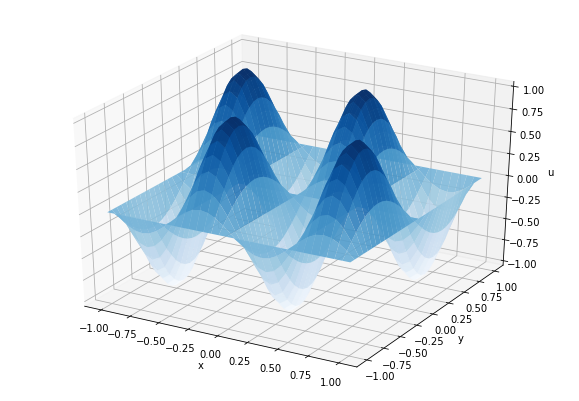

In [10]:
# boundary conditions
g1 = lambda x : 0; g2 = lambda x : 0
g3 = lambda y : 0; g4 = lambda y : 0
g = {"bottom":g1, "top":g2, "left":g3, "right":g4}

xx,yy,uu = fd_poisson_solver(N=32, f_func=f2, g_func=g)
surface_plot(xx,yy,uu)

In [8]:
t0 = time.time()
xx,yy,uu = fd_poisson_solver(N=160, f_func=f2, g_func=g)
print(time.time()-t0)

215.2592658996582


In [12]:
rms_error_fd = []
max_error_fd = []
times_fd = []
for N in range(8, 161, 10):
    t0 = time.time()
    xx,yy,uu = fd_poisson_solver(N=N, f_func=f2, g_func=g)
    times_fd.append( time.time()-t0 )
    uu2 = u2(xx,yy)
    rms_error_fd.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_fd.append( np.max(np.abs(uu2-uu)) )

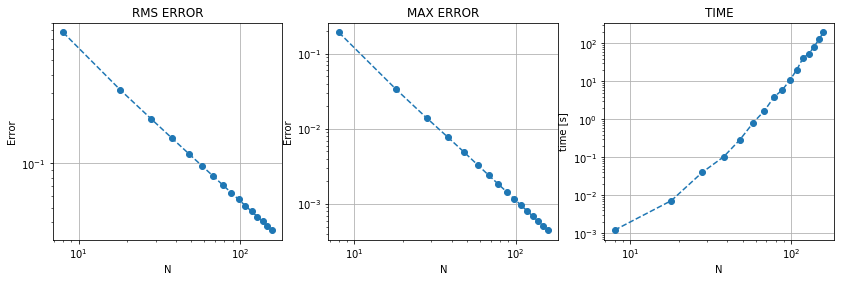

In [26]:
N = list(range(8, 160, 10))

plt.figure(figsize=(14,4))
plt.subplot("131")
plt.loglog(N, rms_error_fd, "o--")
plt.grid()
plt.title("RMS ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("132")
plt.loglog(N, max_error_fd, "o--")
plt.grid()
plt.title("MAX ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("133")
plt.loglog(N, times_fd, "o--")
plt.grid()
plt.title("TIME")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.show()

***
***
## Spectral method

In [32]:
def poisson_solver1(A,B):
    """
    Solution to poisson equation with 
    spectral methods (Kronecker's trick)
    """
    n = A.shape[0]
    # sparse representations are used
    A = csr_matrix(A)
    I = identity(n)
    L = kron(I,A,format="csr")+kron(A,I,format="csr")
    b = np.ravel(B)
    x = spsolve(L, b)
    return np.reshape(x, (n,n)),L

def Lfun(A,x):
    U = x.reshape(A.shape, order="F")
    ret = np.dot(A,U)+np.dot(U,A.T)
    return ret.ravel(order="F")

def poisson_solver2(A, B, m=100, threshold=1e-12):
    """
    Approximate solution to the Sylvester equation
    with GMRes
    
    GMRes code adapted from:
    https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
    """
    b = B.ravel()
    n = b.shape[0]
    x0 = np.zeros(n)
    r0 = b - Lfun(A, x0)  # matrix-free
    nr0 = np.linalg.norm(r0)
    Q = np.zeros((n,m+1))
    H = np.zeros((m+1,m))
    Q[:,0] = r0 / nr0
    flag_break=False
    for k in range(min((m,n))):
        y = Lfun(A, Q[:,k])  # matrix-free
        for j in range(k+1):
            H[j][k] = np.dot(Q[:,j], y)
            y = y - np.dot(H[j][k],Q[:,j])
        if k+1<n:
            H[k+1][k] = np.linalg.norm(y)
            if (np.abs(H[k+1][k]) > 1e-16):
                Q[:,k+1] = y/H[k+1][k]
            else:
                flag_break=True
            e1 = np.zeros((k+1)+1); e1[0]=1
            H_tilde=H[0:(k+1)+1,0:k+1]
        else:
            H_tilde=H[0:k+1,0:k+1]
        ck = np.linalg.lstsq(H_tilde, nr0*e1, rcond=-1)[0] 
        if k+1<n:
            x = x0 + np.dot(Q[:,0:(k+1)], ck)
        else:
            x = x0 + np.dot(Q, ck)
        if flag_break:
            break
    return np.reshape(x, (int(np.sqrt(n)),int(np.sqrt(n)))), H, Q

def spectral_poisson_solver(N=32, f_func=None, method="kronecker"):
    D,x = cheb(N)
    D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    x = x[1:-1]; y = x
    xx,yy = np.meshgrid(x, y)
    ff = f_func(xx,yy)
    if method=="kronecker":
        U,L = poisson_solver1(D2,ff)
    if method=="gmres":
        U,_,_ = poisson_solver2(D2,ff)
    return xx,yy,U

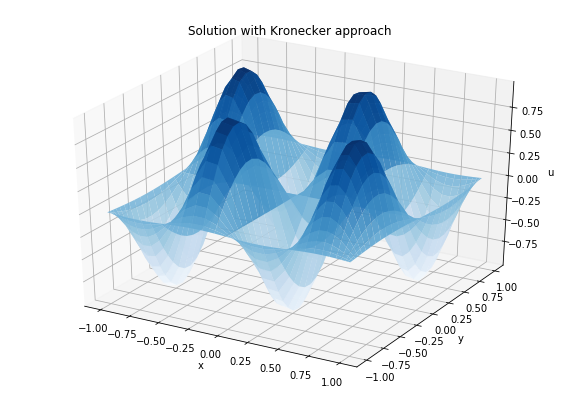

In [33]:
# Solution obtained with the first approach
xx,yy,uu = spectral_poisson_solver(N=32, f_func=f2)
surface_plot(xx,yy,uu, title="Solution with Kronecker approach")
#wireframe_plot(xx, yy, uu, title="Solution with Kronecker approach")

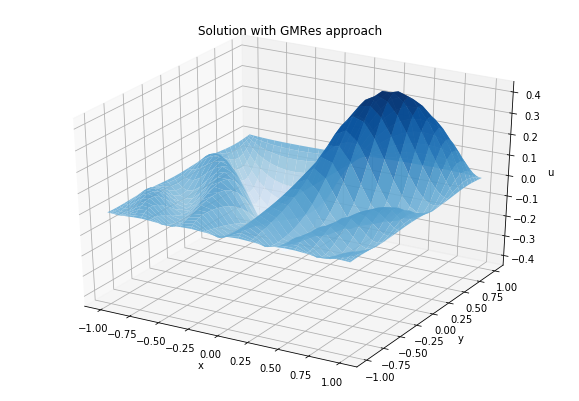

In [34]:
# Solution obtained with the second approach
xx,yy,uu = spectral_poisson_solver(N=32, f_func=f1, method="gmres")
surface_plot(xx,yy,uu, title="Solution with GMRes approach")
#wireframe_plot(xx, yy, uu, title="Solution with GMRes approach")

In [35]:
rms_error_spec = []
max_error_spec = []
times_spec = []
for N in range(8, 161, 10):
    t0 = time.time()
    xx,yy,uu = spectral_poisson_solver(N=N, f_func=f2)
    times_spec.append( time.time()-t0 )
    uu2 = u2(xx,yy)
    rms_error_spec.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_spec.append( np.max(np.abs(uu2-uu)) )

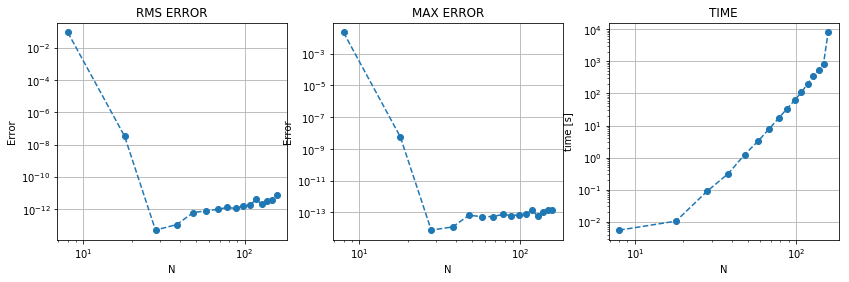

In [37]:
N = list(range(8, 160, 10))

plt.figure(figsize=(14,4))
plt.subplot("131")
plt.loglog(N, rms_error_spec, "o--")
plt.grid()
plt.title("RMS ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("132")
plt.loglog(N, max_error_spec, "o--")
plt.grid()
plt.title("MAX ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("133")
plt.loglog(N, times_spec, "o--")
plt.grid()
plt.title("TIME")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.show()

***
***
## RBF Methods

$$
\phi_j(x,y) = \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right)
$$

$$
\frac{\partial}{\partial x}\phi_j(x,y) = -2\epsilon^2 (x-x_j) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right)
$$

$$
\frac{\partial}{\partial y}\phi_j(x,y) = -2\epsilon^2 (y-y_j) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right)
$$

$$
\frac{\partial^2}{\partial x^2}\phi_j(x,y) = 2\epsilon^2 \left( 2 \epsilon^2 (x-x_j)^2 -1 \right) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right)
$$

$$
\frac{\partial^2}{\partial y^2}\phi_j(x,y) = 2\epsilon^2 \left( 2 \epsilon^2 (y-y_j)^2 -1 \right) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right)
$$

#### Differentation matrices with RBF methods

Let's first consider the set of node points $X=\{\mathbf{x}_1, \ldots, \mathbf{x}_N \}$, a.k.a. collocation points. Lets also consider the RBF interpolant:

$$
u(\mathbf{x}) = \sum_{i=1}^N \lambda_i \phi(\epsilon ||\mathbf{x}-\mathbf{x}_i||^2).
$$

Evaluating $u$ at this set of points give us the following system of equations:

$$
\underbrace{\begin{pmatrix}
\phi(\epsilon||\mathbf{x}_1-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{x}_1-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\phi(\epsilon||\mathbf{x}_N-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{x}_N-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_X}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
u(\mathbf{x}_1) \\ \vdots \\ u(\mathbf{x}_N)
\end{pmatrix}}_{\mathbf{u}_X}
$$

If we consider the linear operator $\mathcal{L}$, the note that applying it to the RBF interpolant $u$ produce:

$$
\mathcal{L}(u(\mathbf{x})) = \sum_{i=1}^N \lambda_i \mathcal{L}\left(\phi(\epsilon ||\mathbf{x}-\mathbf{x}_i ||^2) \right)
$$

where $\mathcal{L}\phi$ is the functions obtained when $\mathcal{L}$ is applied to the basis function $\phi$. Therefore, if we want to compute $\mathcal{L}u$ at a distinct set of points $Y = \{\mathbf{y}_1, \ldots, \mathbf{y}_M \}$ (aka as evaluation points), the way to compute it would be:

$$
\underbrace{\begin{pmatrix}
\phi(\epsilon||\mathbf{y}_1-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{y}_1-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\phi(\epsilon||\mathbf{y}_M-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{y}_N-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_Y^{\mathcal{L}}}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
\mathcal{L}u(\mathbf{y}_1) \\ \vdots \\ \mathcal{L}u(\mathbf{y}_M)
\end{pmatrix}}_{\mathcal{L}\mathbf{u}_Y}
$$

Then note that:

$$
\mathcal{L}\mathbf{u}_Y = \Phi_Y^{\mathcal{L}}\boldsymbol{\lambda} = \underbrace{\Phi_Y^{\mathcal{L}} \Phi_X^{-1}}_{\text{Differentiation Matrix}} \mathbf{u}_X
$$


#### How to solve a Poisson equation with RBF methods?

Let's consider the Poisson problem:

$$
- \Delta u = f \ \ \text{in} \Omega \ \ \text{with BC:} \ \ u=g \ \ \text{in} \ \ \partial \Omega.
$$

Let's define $X$ to the set of interior points in $\Omega$, and $B$ to the set of boundary points in $\partial \Omega$. 

In [38]:
eps = 10.

@numba.jit(nopython=True)
def phi(x, y, eps=eps):
    return np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d1x_phi(x, y, eps=eps):
    return (-2*eps**2) * x * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d2x_phi(x, y, eps=eps):
    return ((4*eps**4)*x**2 - 2*eps**2) * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d1y_phi(x, y, eps=eps):
    return (-2*eps**2) * y * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d2y_phi(x, y, eps=eps):
    return ((4*eps**4)*y**2 - 2*eps**2) * np.exp(-eps**2 *(x**2+y**2))

In [39]:
@numba.jit("float64[:,:] (float64[:], float64[:], float64[:], float64[:], float64)", nopython=True)
def build_phi_maxtrix(x_col, y_col, x_eva, y_eva, eps):
    N = len(x_col)
    M = len(x_eva)
    Phi = np.empty((M,N))
    for i in range(M):
        for j in range(N):
            Phi[i,j] = phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps)
    return Phi

@numba.jit("float64[:,:] (float64[:], float64[:], float64[:], float64[:], float64)", nopython=True)
def build_Lphi_maxtrix(x_col, y_col, x_eva, y_eva, eps):
    N = len(x_col)
    M = len(x_eva)
    LPhi = np.empty((M,N))
    for i in range(M):
        for j in range(N):
            LPhi[i,j] = d2x_phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps) + \
                        d2y_phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps)
    return LPhi

In [40]:
def rbf_poisson_solver(N=32, f_func=None, g_func=None, eps=10., verbose="True",
                       x_nodes=None, y_nodes=None, x_interior=None, y_interior=None,
                       x_boundary=None, y_boundary=None, irregular=False):
    # generating interior/collocation and boundary points
    x = np.linspace(-1.,1.,N+1)
    y = np.linspace(-1.,1.,N+1)
    xx,yy = np.meshgrid(x, y)
    # node points
    if x_nodes is None and y_nodes is None:
        x_nodes = xx.ravel()
        y_nodes = yy.ravel() 
    # interior points
    if x_interior is None and y_interior is None:
        x_interior = xx[1:-1, 1:-1].ravel()
        y_interior = yy[1:-1, 1:-1].ravel()
    # boundary points
    if x_boundary is None and y_boundary is None:
        x_boundary = np.concatenate( (xx[0,:],xx[1:,-1],xx[-1,:-1,],xx[1:-1,0]) )
        y_boundary = np.concatenate( (yy[0,:],yy[1:,-1],yy[-1,:-1,],yy[1:-1,0]) )

    if verbose:
        plt.figure(figsize=(6,6))
        plt.scatter(x_interior, y_interior)
        plt.scatter(x_boundary, y_boundary, c="red")
        plt.grid()
        plt.show()
        print("Number of interior points: {0}".format(len(x_interior)))
        print("Number of boundary points: {0}".format(len(x_boundary)))
        print("Number of node points: {0}".format(len(x_nodes)))
    
    # interior evaluation
    Lphi = build_Lphi_maxtrix(x_nodes, y_nodes, x_interior, y_interior, eps)
    ff = f_func(x_interior, y_interior)

    # boundary evaluation
    Phi = build_phi_maxtrix(x_nodes, y_nodes, x_boundary, y_boundary, eps)
    if g_func is None:
        # by defaul 0 boundary conditions are set
        bb = np.zeros(len(x_boundary))
    else:
        bb = np.concatenate([g_func["bottom"](xx[0,:]),
                             g_func["right"](yy[1:,-1]),
                             g_func["top"](xx[-1,:-1,]),
                             g_func["left"](yy[1:-1,0])])
    
    # building and solving the linear system
    A = np.vstack((Lphi,Phi))
    b = np.hstack((ff,bb))
    lam = np.linalg.solve(A,b)
    
    if irregular:
        return lam
    else:
        # retrieving the solution
        Phi = build_phi_maxtrix(x_nodes, y_nodes, x_nodes, y_nodes, eps)
        u = np.dot(Phi, lam)
        uu = u.reshape((N+1,N+1))
        return xx,yy,uu

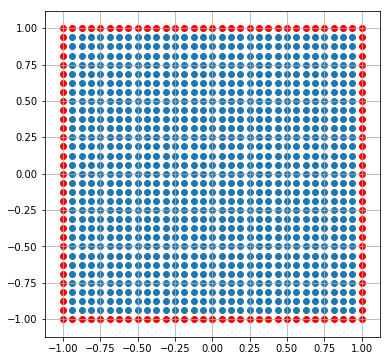

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [41]:
xx,yy,uu = rbf_poisson_solver(N=32, f_func=f2)

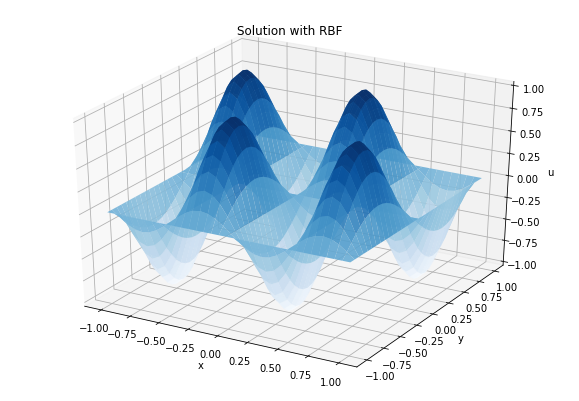

In [42]:
surface_plot(xx, yy, uu, title="Solution with RBF")
#wireframe_plot(xx, yy, uu, title="Solution with RBF")

In [51]:
rms_error_rbf1 = []
max_error_rbf1 = []
times_rbf1 = []
for N in range(8, 161, 10):
    t0 = time.time()
    xx,yy,uu = rbf_poisson_solver(N=N, f_func=f2, verbose=False)
    times_rbf1.append( time.time()-t0 )
    uu2 = u2(xx,yy)
    rms_error_rbf1.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_rbf1.append( np.max(np.abs(uu2-uu)) )
    print(N)
    print("RMS",rms_error_rbf1[-1])
    print("MAX",max_error_rbf1[-1])
    print("------------------------")

8
RMS 3.49798600821
MAX 0.874497270754
------------------------
18
RMS 1.50872598644
MAX 0.173189142221
------------------------
28
RMS 0.305421017188
MAX 0.0350606698552
------------------------
38
RMS 0.186154515185
MAX 0.0157986624697
------------------------
48
RMS 0.0927379530392
MAX 0.00624156326228
------------------------
58
RMS 0.0369868150193
MAX 0.00205009130289
------------------------
68
RMS 0.0117823217494
MAX 0.000554189255847
------------------------
78
RMS 0.00308207358287
MAX 0.000340819358826
------------------------
88
RMS 0.0146310774176
MAX 0.00259830468121
------------------------
98
RMS 0.649813865771
MAX 0.117065429687
------------------------
108
RMS 0.0896681082528
MAX 0.0142517089844
------------------------
118
RMS 0.282334375436
MAX 0.0632934570312
------------------------
128
RMS 2.86486168508
MAX 0.4130859375
------------------------
138
RMS 0.99751929682
MAX 0.166015625
------------------------
148
RMS 0.976290507097
MAX 0.142578125
--------------------

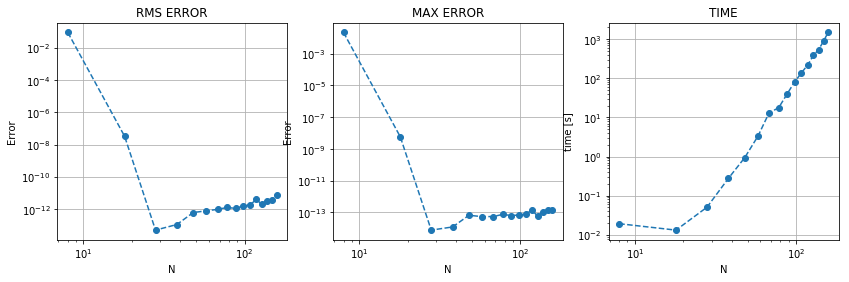

In [45]:
N = list(range(8, 160, 10))

plt.figure(figsize=(14,4))
plt.subplot("131")
plt.loglog(N, rms_error_rbf1, "o--")
plt.grid()
plt.title("RMS ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("132")
plt.loglog(N, max_error_rbf1, "o--")
plt.grid()
plt.title("MAX ERROR")
plt.xlabel("N")
plt.ylabel("Error")
plt.subplot("133")
plt.loglog(N, times_rbf1, "o--")
plt.grid()
plt.title("TIME")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.show()

#### What happen if we place the RBF centers at Chebyshev points?

In [46]:
N = 32
_,x = cheb(N)
y = x
xx,yy = np.meshgrid(x, y)
# node points
x_nodes = xx.ravel()
y_nodes = yy.ravel() 
# interior points
x_interior = xx[1:-1, 1:-1].ravel()
y_interior = yy[1:-1, 1:-1].ravel()
# boundary points
x_boundary = np.concatenate( (xx[0,:],xx[1:,-1],xx[-1,:-1,],xx[1:-1,0]) )
y_boundary = np.concatenate( (yy[0,:],yy[1:,-1],yy[-1,:-1,],yy[1:-1,0]) )

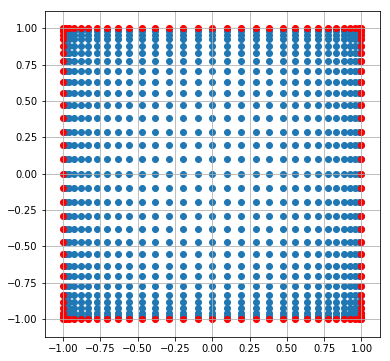

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [47]:
lam = rbf_poisson_solver(f_func=f2, x_nodes=x_nodes, y_nodes=y_nodes, x_interior=x_interior, 
                         y_interior=y_interior, x_boundary=x_boundary, y_boundary=y_boundary, 
                         irregular=True)

Phi = build_phi_maxtrix(x_nodes, y_nodes, x_nodes, y_nodes, eps=10.)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

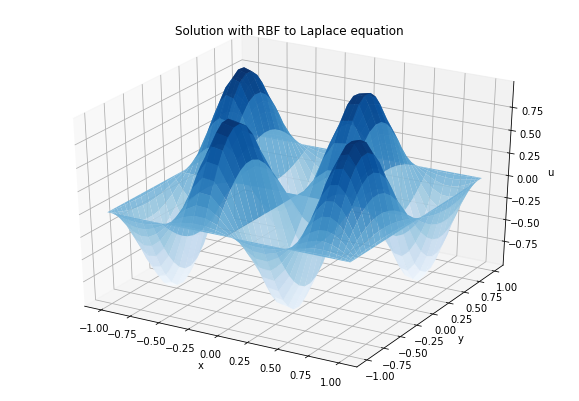

In [48]:
surface_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")
#wireframe_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")

In [ ]:
rms_error_rbf2 = []
max_error_rbf2 = []
times_rbf2 = []
for N in range(8, 161, 10):
    t0 = time.time()
    xx,yy,uu = spectral_poisson_solver(N=N, f_func=f2)
    times_rbf2.append( time.time()-t0 )
    uu2 = u2(xx,yy)
    rms_error_rbf2.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_rbf2.append( np.max(np.abs(uu2-uu)) )

#### Now varying the boundary conditions

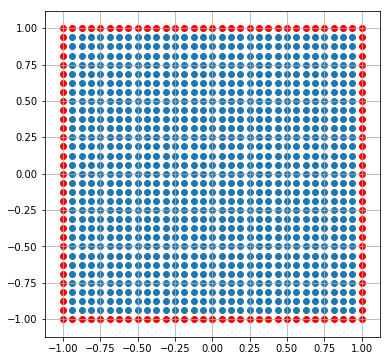

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [643]:
# boundary conditions
g1 = lambda x : np.zeros(len(x)); g2 = lambda x : np.zeros(len(x))
g3 = lambda y : np.sin(np.pi*y); g4 = lambda y : np.sin(np.pi*y) 
g = {"bottom":g1, "top":g2, "left":g3, "right":g4}

xx,yy,uu = rbf_poisson_solver(N=32, f_func=f1, g_func=g)

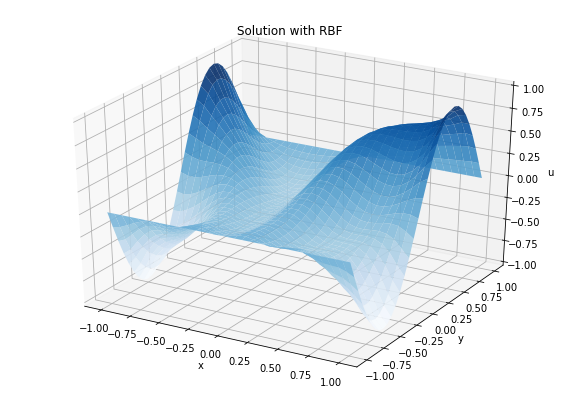

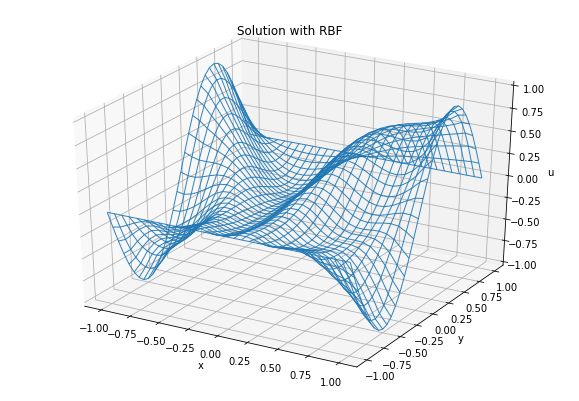

In [644]:
surface_plot(xx,yy,uu, title="Solution with RBF")
wireframe_plot(xx,yy,uu, title="Solution with RBF")

#### Solving PDEs over irregular domains

In [516]:
def circular_grid(N):
    sequencer = ghalton.Halton(2)
    selected_points = []
    while True:
        points = 2*np.asarray(sequencer.get(50))-1
        for i in range(50):
            if points[i,0]**2+points[i,1]**2<=0.9:
                selected_points.append(points[i])
            if len(selected_points)==N:
                return np.asarray(selected_points)

In [517]:
# interior points
points = circular_grid(300)
x_interior = points[:,0]
y_interior = points[:,1]

# boundary points
x_boundary = np.cos(np.linspace(0, 2*np.pi, 50))
y_boundary = np.sin(np.linspace(0, 2*np.pi, 50))

# node points
x_nodes = np.hstack([x_interior, x_boundary])
y_nodes = np.hstack([y_interior, y_boundary])

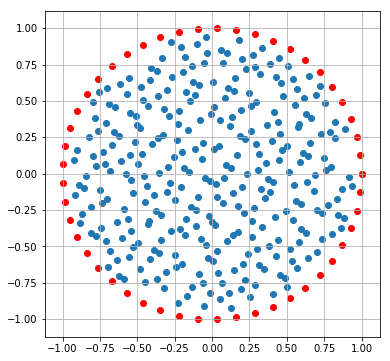

Number of interior points: 300
Number of boundary points: 50
Number of node points: 350


In [518]:
lam = rbf_poisson_solver(f_func=f1, x_nodes=x_nodes, y_nodes=y_nodes, x_interior=x_interior, 
                              y_interior=y_interior, x_boundary=x_boundary, y_boundary=y_boundary, irregular=True)

In [519]:
# generating interior/collocation and boundary points
N = 32
x = np.linspace(-1.,1.,N+1)
y = np.linspace(-1.,1.,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_maxtrix(x_nodes, y_nodes, x, y, eps=10.)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

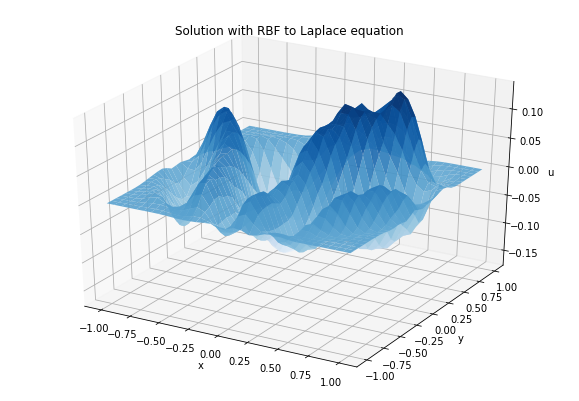

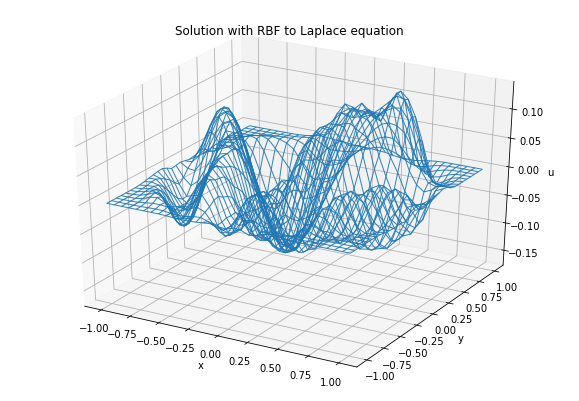

In [520]:
surface_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")
wireframe_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")

#### Pros of RBF methods for computing differentiation matrices
* Spectral accuracy
* Easily extensible to non-square [-1,1] domains.
* Applicable to more realistic scenarios, where the value of $\Delta u$ is only accessible at scattered points in a  irregular domain.

#### Contras of RBF methods for computing differentiation matrices
* We need to set the shape parameter $\epsilon$ accordingly to obtain a accurate solution.
* As $\epsilon \rightarrow 0$ the interpolation matrix $\Phi$ becomes ill-conditioned.